In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [2]:
import random
# import tools
import numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import time
import knapsack

In [ ]:
knapsack = knapsack.Knapsack01Problem()

In [4]:
# Genetic Algorithm constants:
POPULATION_SIZE = 100
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.3   # probability for mutating an individual
MAX_GENERATIONS = 1000
HALL_OF_FAME_SIZE = 1

In [5]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [6]:
def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

In [14]:
#Evolution algorithm
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    gen = 1
    while gen <= ngen:
        gen+=1
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [8]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(knapsack))

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [10]:
# fitness calculation
def knapsackValue(individual):
    return knapsack.getValue(individual),  # return a tuple

In [11]:
toolbox.register("evaluate", knapsackValue)

# genetic operators:mutFlipBit

# Tournament selection with tournament size of 3:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(knapsack))

In [15]:
# Genetic Algorithm flow:
def main():
    
    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", numpy.max)
    stats.register("avg", numpy.mean)


    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)


    # print best solution found:
    best = hof.items[0]
    print("-- Best Ever Individual = ", best)
    print("-- Best Ever Fitness = ", best.fitness.values[0])

    print("-- Knapsack Items = ")
    knapsack.printItems(best)

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:x
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()

gen	nevals	max	avg   
0  	100   	820	570.05
2  	98    	897	659.39
3  	93    	897	729.11
4  	95    	945	781.21
5  	93    	970	833.92
6  	95    	980	864.18
7  	90    	980	886.47
8  	100   	1030	916.36
9  	95    	985 	937.73
10 	91    	985 	939.64
11 	94    	985 	944.85
12 	92    	985 	947.85
13 	94    	990 	947.79
14 	89    	1000	939.26
15 	96    	1000	925.36
16 	91    	1000	950.04
17 	94    	1000	952.03
18 	95    	1000	949.95
19 	90    	1005	955.87
20 	93    	1005	968.32
21 	89    	1000	984.06
22 	88    	1000	983.89
23 	95    	1000	978.1 
24 	92    	1000	976.44
25 	98    	1000	981.76
26 	90    	1000	987.44
27 	86    	1000	987.76
28 	95    	1000	976.6 
29 	90    	1000	990.02
30 	92    	1030	983.77
31 	91    	1030	979.51
32 	89    	1030	990.29
33 	94    	1030	985.01
34 	96    	1030	978.12
35 	93    	1030	978.45
36 	97    	1030	989.01
37 	96    	1030	985.24
38 	93    	1030	1007.3
39 	90    	1030	1013.42
40 	93    	1030	1000.57
41 	95    	1030	1011.11
42 	98    	1030	1011.6 
43 	94    	1030

361	90    	1030	1015.49
362	96    	1030	1010.44
363	95    	1030	1010.53
364	94    	1030	1007.03
365	96    	1030	1014.43
366	95    	1030	1013.56
367	100   	1030	1011.64
368	92    	1030	1011.9 
369	91    	1030	1012.2 
370	95    	1030	1004.75
371	92    	1030	1015.65
372	91    	1030	1007.46
373	88    	1030	1010.69
374	96    	1030	1012.7 
375	95    	1030	1012.23
376	99    	1030	1017.39
377	95    	1030	1007.39
378	90    	1030	1009.58
379	95    	1030	997.92 
380	94    	1030	1010.97
381	89    	1030	1009.24
382	93    	1030	1013.05
383	95    	1030	1004.42
384	91    	1030	994.33 
385	95    	1030	1011.6 
386	85    	1030	1010.29
387	93    	1030	1007.49
388	92    	1030	999.83 
389	88    	1030	1010.13
390	95    	1030	1008.52
391	86    	1030	1000.9 
392	96    	1030	1012.65
393	93    	1030	1012.88
394	95    	1030	1009.08
395	85    	1030	1007.49
396	94    	1030	1010.83
397	93    	1030	1005.48
398	99    	1030	1002.73
399	90    	1030	1019.86
400	91    	1030	999.03 
401	89    	1030	1016.58
402	94    	1030	

704	92    	1030	1011.28
705	83    	1030	1009.28
706	97    	1030	1008.65
707	91    	1030	1018.72
708	99    	1030	1010.64
709	91    	1030	1004.43
710	96    	1030	1005.84
711	94    	1030	1010.88
712	89    	1030	1013.99
713	98    	1030	1000.61
714	94    	1030	1017.49
715	85    	1030	1011.14
716	91    	1030	1007.33
717	97    	1030	1007.45
718	97    	1030	1007.89
719	97    	1030	1006.96
720	97    	1030	995.37 
721	100   	1030	1007.63
722	91    	1030	1014.04
723	89    	1030	1015.82
724	98    	1030	1012.2 
725	95    	1030	1013.42
726	91    	1030	1011.75
727	90    	1030	1004.69
728	92    	1030	1005.11
729	93    	1030	1007.55
730	96    	1030	1018.02
731	91    	1030	1016.03
732	95    	1030	1012.56
733	90    	1030	1005.6 
734	96    	1030	1007.08
735	97    	1030	1011.62
736	99    	1030	1008.37
737	98    	1030	1014.14
738	94    	1030	1004.71
739	97    	1030	1007.07
740	93    	1030	1016.37
741	86    	1030	1017.84
742	97    	1030	1005.72
743	89    	1030	1013.17
744	98    	1030	1007.9 
745	95    	1030	

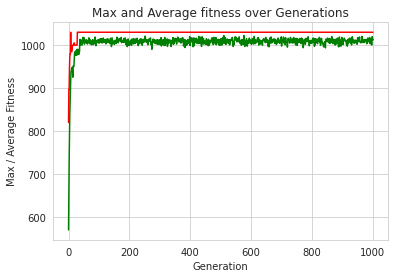

In [16]:
if __name__=='__main__':
    main()